1. Detect the squares that bounds each single dice
2. For each of these squares, detect the dots that are inside and count them

In [287]:
import numpy as np
import os
import cv2
from matplotlib import pylab as plt 
from ipywidgets import interact

Images before Canny

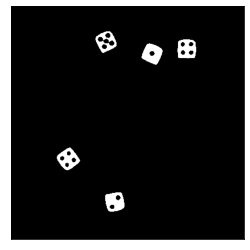

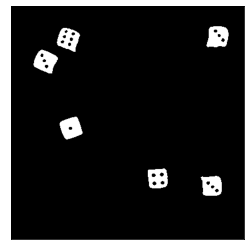

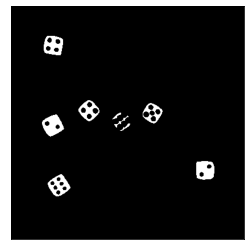

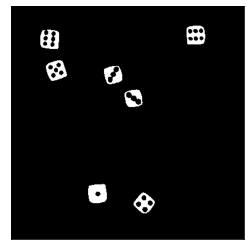

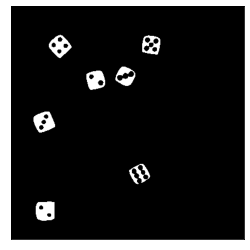

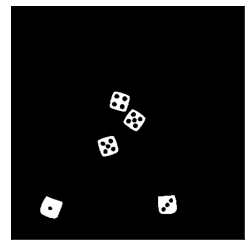

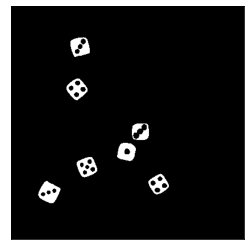

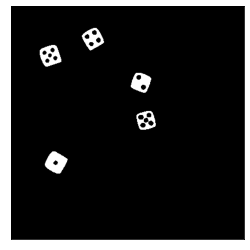

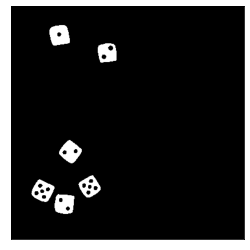

In [288]:
#directory = r'./images'
directory = r'./dices/selected-dataset-images'
#directory = r'./dices/board-game-dices'
#directory = r'./dices/selected-board-game-dices'

dices = []
original_dices = []
i = 0
for dice_image in os.scandir(directory):
    dices.append(dice_image.path)
    
    plt.figure(figsize=(30, 30))

    img = cv2.imread(dices[i])
    original_dices.append(img)
    
    # 0. Change colorscale to gray
    imggrayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 1. Blurring dices to remove sharp edges
    blur = cv2.blur(imggrayscale, (4, 4), 0)
    #dices[i] = cv2.blur(imggrayscale, (4, 4), 0)

    # 2. Threshold
    _, dices[i] = cv2.threshold(blur, 140, 255, cv2.THRESH_BINARY)
    
    ax = plt.subplot(6, 3, i+1)
    ax.imshow(dices[i], cmap='gray')
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, img.shape[1], img.shape[0], 0])
    
    i += 1
    

In [289]:

@interact(blur_edge=(2, 5, 1), thresh=(0, 250, 10), canny=(100, 540, 10))
def func(blur_edge, thresh, canny):
    dices = []
    original_dices = []
    i = 0
    for dice_image in os.scandir(directory):
        dices.append(dice_image.path)
        
        plt.figure(figsize=(30, 30))

        img = cv2.imread(dices[i])
        original_dices.append(img)
        
        # 0. Change colorscale to gray
        imggrayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # 1. Blurring dices to remove sharp edges
        blur = cv2.blur(imggrayscale, (blur_edge, blur_edge), 0)
        
        # 2. Threshold
        _, thresholded = cv2.threshold(blur, thresh, 255, cv2.THRESH_BINARY)
        
        # 3. Canny filter to detect edges 
        dices[i] = cv2.Canny(thresholded, canny, 550)
    
        ax = plt.subplot(6, 3, i+1)
        ax.imshow(dices[i], cmap='gray')
        ax.set_xticks([]), ax.set_yticks([])
        ax.axis([0, img.shape[1], img.shape[0], 0])
        
        i += 1
        
        
    #dices

interactive(children=(IntSlider(value=3, description='blur_edge', max=5, min=2), IntSlider(value=120, descript…

1. Finding contours.
2. Finding the minimum area rectangles that enclose all the points of each contours.

In [290]:
def plot_histogram(data, min_area, max_area):
    
    histo, x = np.histogram(img, range(0, 256), density=True)
    plot(histo)
    xlim(0, 255)

In [291]:
# lowest point of the rectangle will always be the first sub list of box ndarray
# the next sub-list will always represent the point that you first get when you move in the clockwise direction


# TODO: def is_inside(box1, box2):
    
    

In [292]:
# TODO: count dots inside a single dice
# TODO: count how many dices are there


In [293]:
# Returns the centre point of box
# def centre_of_box(box):
    

{0: 2, 1: 4, 2: 1, 3: 4, 4: 3}
dice_count:  5  dot_count:  14
{0: 3, 1: 4, 2: 1, 3: 3, 4: 6, 5: 3}
dice_count:  6  dot_count:  20
{0: 6, 1: 2, 2: 2, 3: 4, 4: 4, 5: 4}
dice_count:  6  dot_count:  25
{0: 4, 1: 1, 2: 0, 3: 0, 4: 1, 5: 5, 6: 3, 7: 6}
dice_count:  8  dot_count:  20
{0: 2, 1: 1, 2: 3, 3: 2, 4: 1, 5: 4, 6: 4}
dice_count:  7  dot_count:  17
{0: 1, 1: 3, 2: 5, 3: 5, 4: 4}
dice_count:  5  dot_count:  18
{0: 3, 1: 4, 2: 5, 3: 1, 4: 1, 5: 4, 6: 3}
dice_count:  7  dot_count:  21
{0: 1, 1: 5, 2: 2, 3: 5, 4: 4}
dice_count:  5  dot_count:  17
{0: 2, 1: 5, 2: 5, 3: 2, 4: 2, 5: 1}
dice_count:  6  dot_count:  17


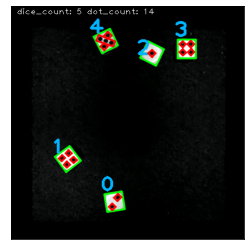

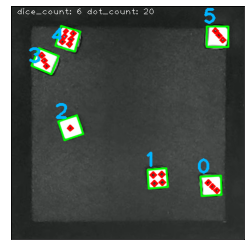

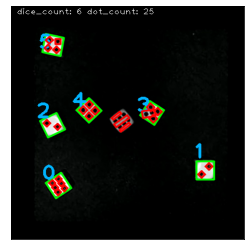

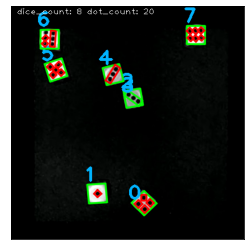

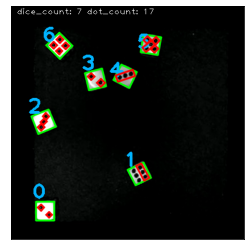

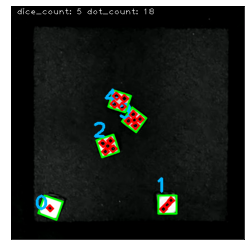

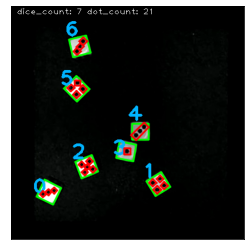

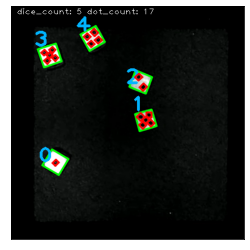

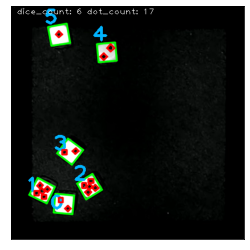

In [294]:
i = 0
dice_areas = []
for dice_image, original in zip(dices, original_dices):
    
    plt.figure(figsize=(30, 30))
   
    # 4. Finding contours of an image.
    contours, hierarchy = cv2.findContours(dice_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print(hierarchy)

    # 5. Calculating areas of found contours.
    areas = []
    boxes_with_points = [] 
    for contour in contours:
        _, _, width, height = cv2.boundingRect(contour)
        #boxes_with_points.append(cv2.boxPoints(contour))
        areas.append(width*height)
        
    dice_areas.append(areas)
    # print(max(areas), min(areas))
    # print(areas)
    # print(len(areas))
    

    # 6.0 Checking if dots are inside dices boxes
    #  [Next, Previous, First_Child, Parent]
    for contour in hierarchy[0][0]:
        pass

    # 6.1 Using average as a middle point to differ between dots and dices boxes
    labels = []
    dice_dict = {}
    dice_count = 0
    middle = (max(areas) - min(areas)) / 2
    #print(middle)
    for area in areas:
        if area > middle:
            labels.append('kostka')
            dice_dict[dice_count] = 0
            dice_count += 1
        else: 
            labels.append('oczko')

    
    # dla każdego oczka sprawdzamy w jakiej jest kostce
    # mamy labels, ale potrzebujemy lokalizacji oczek i konturów kostek
    
    
    dice_count = 0
    dot_count = 0
    for contour, label in zip(contours, labels):
        
         # 7. Drawing contours according to labels.
        rectangle = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rectangle)
        box = np.int0(box)
        
        if label == 'kostka':
            cv2.drawContours(original, [box], -1, (0, 255, 0), 2,  cv2.LINE_AA)
            # id of dice
            cv2.putText(original, str(dice_count), (box[0][0] - 7, box[0][1] - 5), cv2.FONT_HERSHEY_PLAIN, 2.5, (0, 180, 255), 3)
            dice_count += 1
            
            
        elif label == 'oczko':
            cv2.drawContours(original, [box], -1, (255, 0, 0), 2,  cv2.LINE_AA)
            
            # finding centroids of dots
            M = cv2.moments(contour)
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            #cv2.circle(original, (cX, cY), 5, (255, 255, 255), -1)
            
            # if dice is found, ++ 
            k = 0
            c = 0
            for label in labels:
                if label == 'kostka':
                    result = cv2.pointPolygonTest(contours[c], (cX, cY), False)
                    if result > 0:
                        dice_dict[k] += 1
                    # if centroid is in kontur
                        # dice_dict[k] += 1
                        # contours[k]
                    k += 1
                c += 1
                    
            dot_count += 1
            
    print(dice_dict)
            
    # 8. Put dice count and dot count text on a black image
    cv2.putText(original, "dice_count: "+ str(dice_count) + " dot_count: "+ str(dot_count), (10,15), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))
            
    ax = plt.subplot(6, 3, i+1)
    ax.imshow(original)
    ax.set_xticks([]), ax.set_yticks([])
    ax.axis([0, original.shape[1], original.shape[0], 0])
    print("dice_count: ", dice_count, " dot_count: ", dot_count)
    

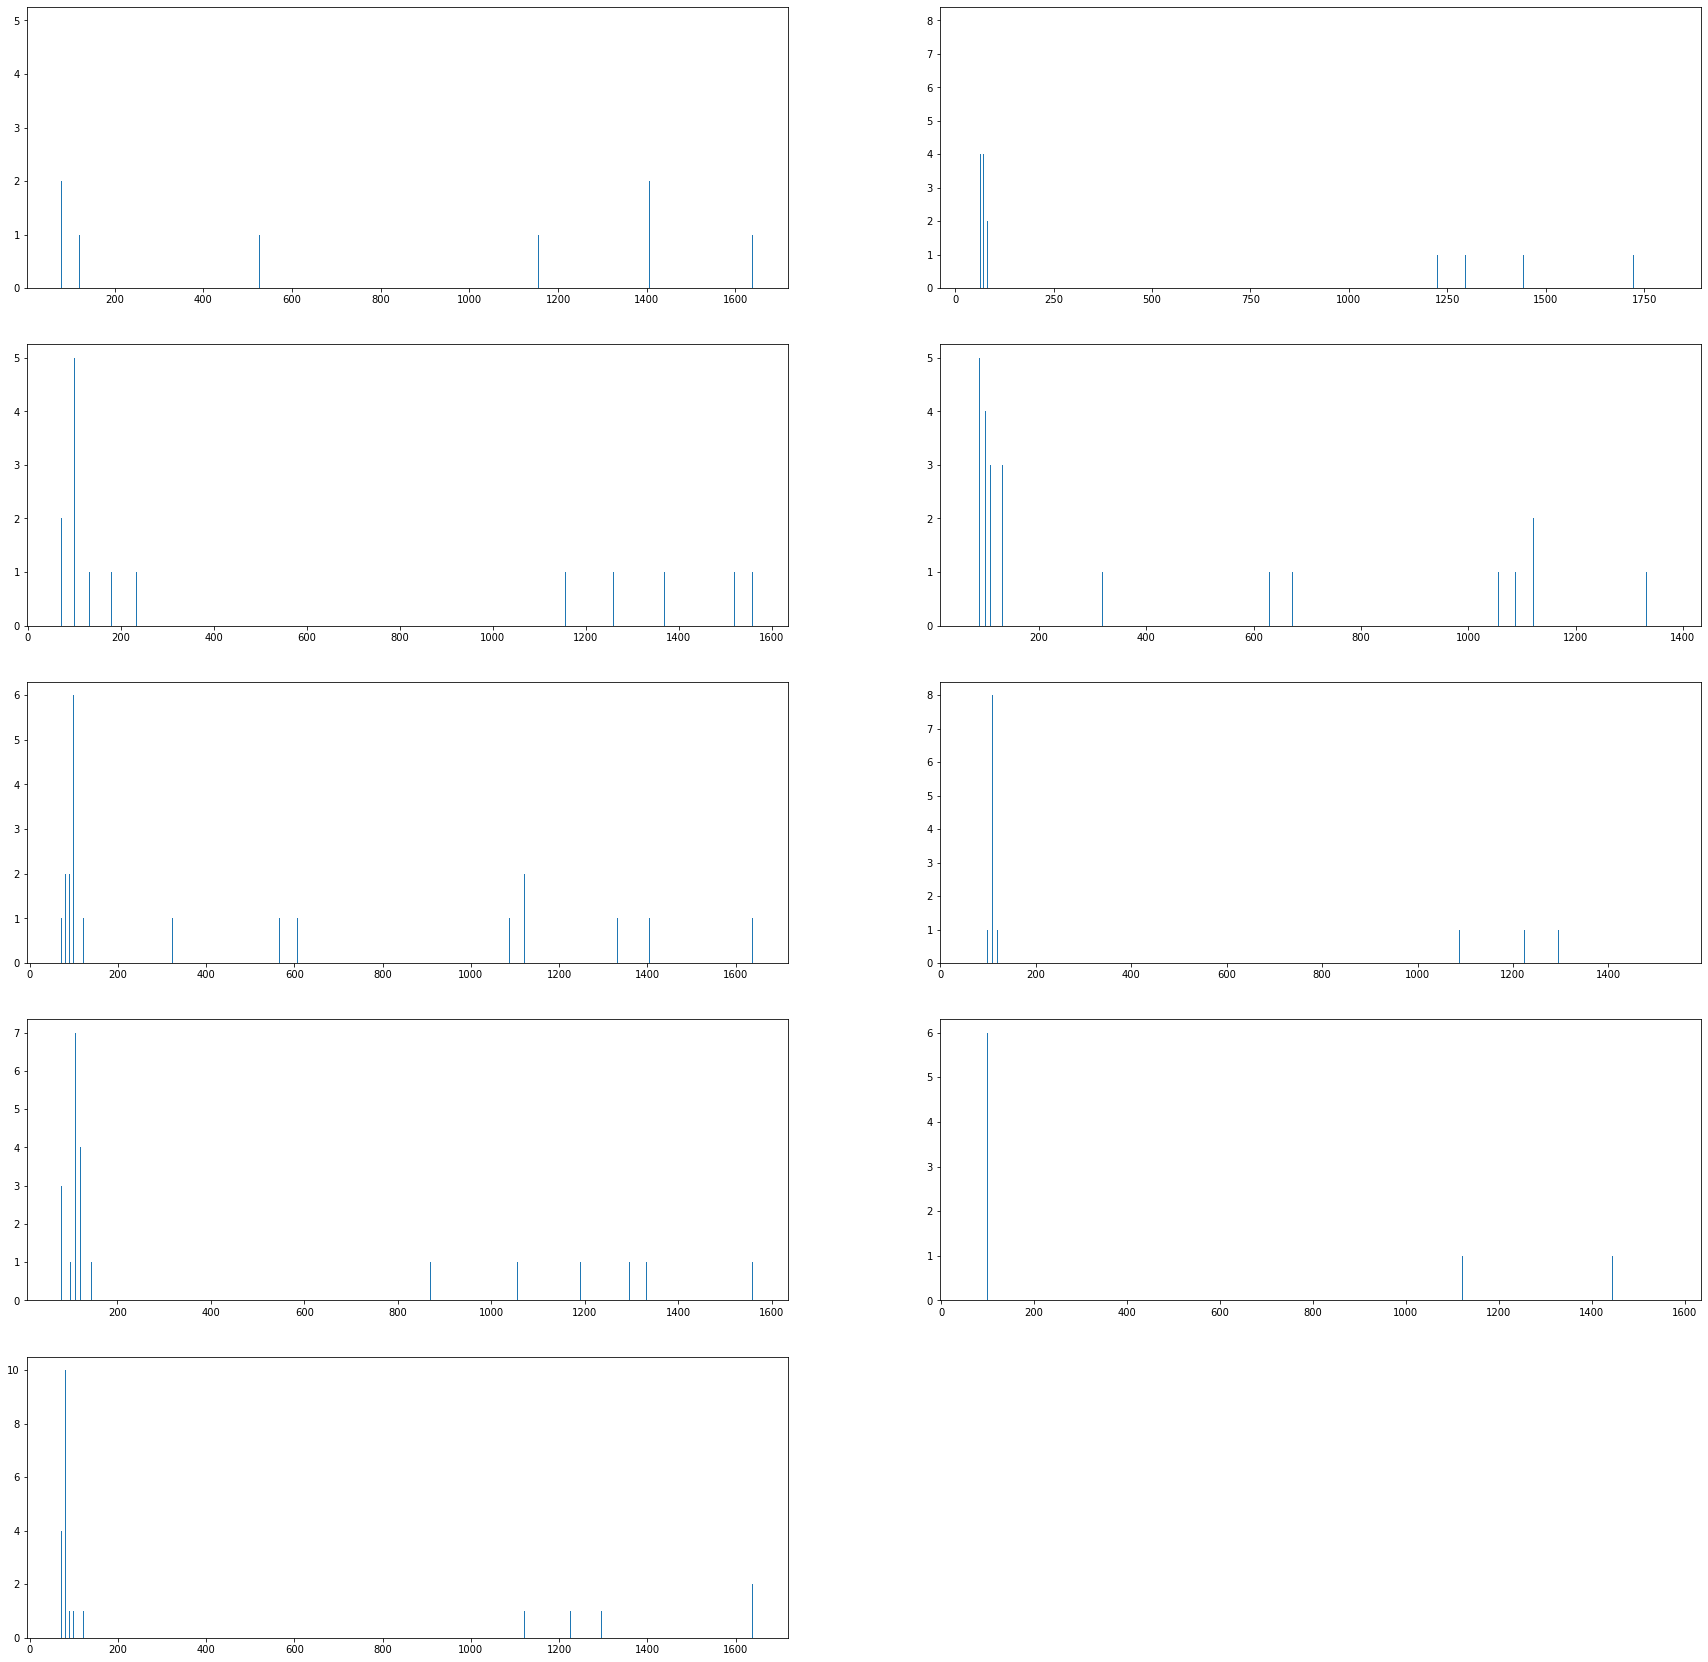

In [295]:
plt.figure(figsize=(30, 30))
i = 0
for area in dice_areas:
    
    ax1 = plt.subplot(5, 2, i+1)
    ax1.hist(area, bins=1000)
    i += 1
    
    